In [72]:
from cycle_gan import load_checkpoint
import cycle_gan

parser = cycle_gan.create_parser()
opts, _ = parser.parse_known_args()
opts.g_conv_dim = 32
opts.d_conv_dim = 32
opts.init_zero_weights = False
opts.load = '/Users/snow0w/repos/ADD/CycleGAN/checkpoints_cyclegan'
opts.data_dir = '/Users/snow0w/repos/ADD/DeepGenerativeModels/CycleGAN/data/horse2zebra'
G_XtoY, G_YtoX, D_X, D_Y = load_checkpoint(opts)
from data_loader import get_loaders
opts.batch_size = 1
dataloader_X, test_dataloader_X = get_loaders(img_type=opts.X, opts=opts)
dataloader_Y, test_dataloader_Y = get_loaders(img_type=opts.Y, opts=opts)
test_iter_X = iter(test_dataloader_X)
test_iter_Y = iter(test_dataloader_Y)

Models moved to mps.


In [73]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms

# Функция для денормализации - исправленная версия
def denormalize(tensor, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """
    Денормализует тензор изображения.
    tensor: тензор формы (C, H, W) или (B, C, H, W)
    """
    # Создаем копию тензора
    tensor = tensor.clone()
    
    # Проверяем размерность тензора
    if tensor.dim() == 3:  # (C, H, W)
        # Преобразуем mean и std в тензоры нужной размерности
        mean = torch.tensor(mean).view(-1, 1, 1)
        std = torch.tensor(std).view(-1, 1, 1)
    elif tensor.dim() == 4:  # (B, C, H, W)
        mean = torch.tensor(mean).view(1, -1, 1, 1)
        std = torch.tensor(std).view(1, -1, 1, 1)
    
    # Денормализуем без inplace операций над view'ами
    tensor = tensor * std + mean
    
    # Ограничиваем значения в диапазоне [0, 1] для корректного отображения
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

def imshow(x, G, title=None):
    # Получаем батч данных
    batch = next(x)
    
    # Берем первое изображение из батча
    if isinstance(batch, (list, tuple)):
        tensor = batch[0].clone()
    else:
        tensor = batch.clone()
    
    # Если тензор имеет размерность (B, C, H, W), берем первый элемент
    if tensor.dim() == 4:
        tensor = tensor[0].unsqueeze(0)  # Берем первый элемент и сохраняем размерность
    
    # Денормализуем оригинальное изображение
    orig_denorm = denormalize(tensor)
    
    # Пропускаем через генератор
    with torch.no_grad():
        generated = G(tensor)
    
    # Денормализуем сгенерированное изображение
    gen_denorm = denormalize(generated)
    
    # Преобразуем в numpy для отображения
    if orig_denorm.dim() == 4:
        orig_np = orig_denorm[0].numpy().transpose(1, 2, 0)
        gen_np = gen_denorm[0].numpy().transpose(1, 2, 0)
    else:
        orig_np = orig_denorm.numpy().transpose(1, 2, 0)
        gen_np = gen_denorm.numpy().transpose(1, 2, 0)
    
    # Отображаем
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(orig_np)
    axes[0].axis('off')
    axes[0].set_title("Original", fontsize=14)
    
    axes[1].imshow(gen_np)
    axes[1].axis('off')
    axes[1].set_title("Generated", fontsize=14)
    
    if title:
        fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()



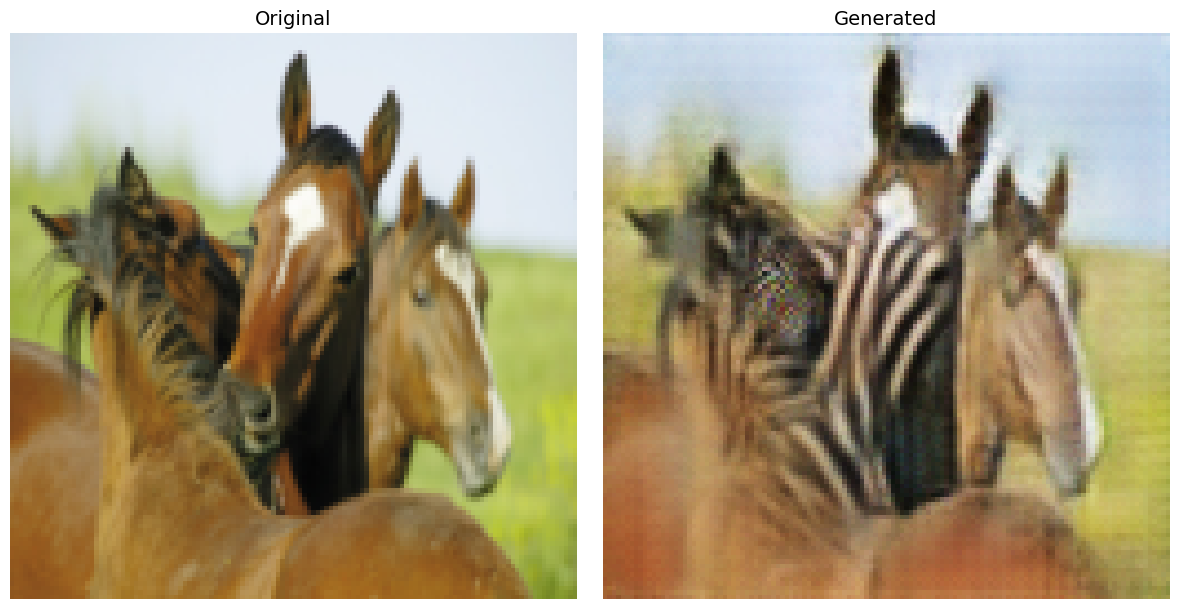

In [75]:
G_XtoY.to('cpu')
G_XtoY.eval()
imshow(test_iter_X, G_XtoY)